In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

file_path = '/content/drive/MyDrive/Data Science Project/updated_coresets_train_dataset_230K.pkl'

try:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    print("Pickle file loaded successfully!")
    print(data)
except FileNotFoundError:
    print(f"File not found: {file_path}")
except pickle.UnpicklingError:
    print("Error while unpickling the file. It might be corrupted or not a pickle file.")
except Exception as e:
    print(f"An error occurred: {e}")


Pickle file loaded successfully!
{'coreset_matrix': array([[ 8.56748668e-01, -6.32485247e-02, -3.49392806e+00, ...,
         2.76441115e-01,  1.27401897e+00,  6.37675800e-01],
       [ 8.56748668e-01,  1.69750672e+01,  2.86210816e-01, ...,
         3.76006491e-02,  1.02507302e+01,  6.37675800e-01],
       [ 8.56748668e-01,  2.10193809e+02,  2.86210816e-01, ...,
        -3.55901441e-01, -3.99899163e-01,  6.37675800e-01],
       ...,
       [-1.49501043e+00, -6.32485247e-02,  2.86210816e-01, ...,
         1.88273657e+00,  5.19454839e-01, -2.07691824e+00],
       [-1.49501043e+00, -6.32485247e-02, -3.49392806e+00, ...,
         1.08322300e+00, -1.13685182e-01,  6.37675800e-01],
       [-1.49501043e+00, -6.32485247e-02, -3.49392806e+00, ...,
        -1.71726123e-02,  5.04683964e+00,  6.37675800e-01]]), 'labels': array([2, 2, 1, ..., 0, 0, 2]), 'weights': array([1.12524340e+01, 4.32394531e-01, 3.86253462e-03, ...,
       8.40850885e+00, 8.88170005e+00, 4.22234093e+00])}


In [ ]:
train_labels = data['labels']
coreset_matrix = data.get('coreset_matrix')

if coreset_matrix is not None:
    print("Coreset matrix extracted successfully!")
    print(coreset_matrix.shape)
else:
    print("Coreset matrix not found in the pickle data.")

print(train_labels)

Coreset matrix extracted successfully!
(235415, 7)
[2 2 1 ... 0 0 2]


In [ ]:
import numpy as np

coreset_matrix = data['coreset_matrix']
original_dim = coreset_matrix.shape[1]
reduced_dim = 3

jl_matrix = np.random.normal(0, 1 / np.sqrt(reduced_dim), (original_dim, reduced_dim))
reduced_matrix = np.dot(coreset_matrix, jl_matrix)

print("Reduced matrix shape:", reduced_matrix.shape)


Reduced matrix shape: (235415, 3)


In [ ]:
import pickle

file_path = '/content/drive/MyDrive/Data Science Project/coresets_test_dataset.pkl'

try:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    print("Pickle file loaded successfully!")
    print(data)
except FileNotFoundError:
    print(f"File not found: {file_path}")
except pickle.UnpicklingError:
    print("Error while unpickling the file. It might be corrupted or not a pickle file.")
except Exception as e:
    print(f"An error occurred: {e}")


Pickle file loaded successfully!
{'data': array([[ 0.85739503, -0.09300814,  0.2861384 , ..., -1.3142678 ,
        -0.37142598,  0.63789825],
       [ 0.85739503, -0.09300814,  0.2861384 , ..., -1.3142678 ,
        -0.45762576,  0.63789825],
       [-1.49604894, -0.09300814,  0.2861384 , ..., -0.03501672,
        -0.56968548,  0.63789825],
       ...,
       [ 0.85739503, -0.09300814, -3.49481229, ...,  0.81781733,
        -0.22488635, -1.39874422],
       [-1.49604894, -0.09300814,  0.2861384 , ...,  0.31677733,
         0.55091167,  0.63789825],
       [-0.31932695, -0.09300814,  0.2861384 , ..., -1.3142678 ,
        -0.49210567, -0.7198634 ]]), 'labels': array([1, 1, 0, ..., 0, 0, 1])}


In [ ]:
data['labels'].shape

(637707,)

In [ ]:
from scipy.stats import zscore

test_labels = data['labels']

z_scores = zscore(reduced_matrix, axis=0)
outlier_threshold = 3
non_outlier_indices = (np.abs(z_scores) < outlier_threshold).all(axis=1)

# print(reduced_matrix.shape)

filtered_train_data = reduced_matrix[non_outlier_indices]


# test_labels = test_labels[:len(reduced_matrix)]
# filtered_test_labels = test_labels[non_outlier_indices]


# filtered_train_data = filtered_train_data[:235415]
# filtered_test_labels = filtered_test_labels[:235415]


reduced_train_data = filtered_train_data
# test_labels = filtered_test_labels


In [ ]:
print(reduced_train_data.shape)
print(test_labels.shape)

(231020, 3)
(637707,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, adjusted_rand_score
from numpy.linalg import pinv
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import mode
import time


test_data = data['data']

k = 3  # Number of clusters

def map_clusters_to_labels(clusters, true_labels):
    """Maps clusters to labels using majority voting and avoids reassignment conflicts."""
    mapping = {}
    already_assigned = []
    for cluster in set(clusters):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster]
        cluster_true_labels = [true_labels[i] for i in cluster_indices]
        if not cluster_true_labels:
            print(f"No true labels found for cluster {cluster}. Skipping...")
            continue
        count_zero = cluster_true_labels.count(0)
        count_one = cluster_true_labels.count(1)
        count_two = cluster_true_labels.count(2)

        zero, one, two = 0, 1, 2

        if count_zero > count_one and count_zero > count_two:
            if zero not in already_assigned:
                already_assigned.append(zero)
                mapping[cluster] = zero
            else:
                if count_one > count_two and one not in already_assigned:
                    already_assigned.append(one)
                    mapping[cluster] = one
                else:
                    already_assigned.append(two)
                    mapping[cluster] = two
        elif count_one > count_zero and count_one > count_two:
            if one not in already_assigned:
                already_assigned.append(one)
                mapping[cluster] = one
            else:
                if count_zero > count_two and zero not in already_assigned:
                    already_assigned.append(zero)
                    mapping[cluster] = zero
                else:
                    already_assigned.append(two)
                    mapping[cluster] = two
        else:
            if two not in already_assigned:
                already_assigned.append(two)
                mapping[cluster] = two
            else:
                if count_one > count_zero and one not in already_assigned:
                    already_assigned.append(one)
                    mapping[cluster] = one
                else:
                    already_assigned.append(zero)
                    mapping[cluster] = zero
    return mapping


min_value = np.min(reduced_train_data)
if min_value <= 0:
    reduced_train_data_shifted = reduced_train_data - min_value + 1
else:
    reduced_train_data_shifted = reduced_train_data


log_transformed_data = np.log1p(reduced_train_data_shifted)


start_time = time.time()
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(log_transformed_data)
kmeans_labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_
kmeans_training_time = time.time() - start_time

print(f"KMeans Training Time : {kmeans_training_time:.4f} seconds")


kmeans_cluster_to_label = map_clusters_to_labels(kmeans_labels, train_labels)
# kmeans_mapped_labels = np.array([kmeans_cluster_to_label[cluster] for cluster in kmeans_labels])

pseudo_inverse_jl_matrix = pinv(jl_matrix)
original_dim_kmeans_centers = np.dot(kmeans_cluster_centers, pseudo_inverse_jl_matrix)
kmeans_wcss = sum(
    np.sum(np.linalg.norm(
        np.dot(log_transformed_data[kmeans_labels == i], pseudo_inverse_jl_matrix) - original_dim_kmeans_centers[i],
        axis=1) ** 2)
    for i in range(k)
)

print("KMeans WCSS Score ", kmeans_wcss)

# complete test data
transformed_test_data = np.log1p(test_data)[:, np.newaxis]

transformed_centroids = np.dot(kmeans_cluster_centers, pseudo_inverse_jl_matrix)

# print(transformed_centroids.shape)

kmeans_predict_clusters = np.argmin(np.linalg.norm( transformed_test_data - transformed_centroids, axis=2), axis=1)

kmeans_mapped_labels = np.array([kmeans_cluster_to_label[cluster] for cluster in kmeans_predict_clusters])

kmeans_accuracy = accuracy_score(test_labels, kmeans_mapped_labels)
kmeans_rand_index = adjusted_rand_score(test_labels, kmeans_mapped_labels)
print(f"KMeans Accuracy: {kmeans_accuracy * 100:.2f}%")
print(f"KMeans RAND Index: {kmeans_rand_index:.4f}")



KMeans Training Time : 0.2904 seconds
KMeans WCSS Score  9553.192560182095


<ipython-input-9-aa80f94a2c56>:103: RuntimeWarning: invalid value encountered in log1p
  transformed_test_data = np.log1p(test_data)[:, np.newaxis]


KMeans Accuracy: 33.10%
KMeans RAND Index: 0.0006


GMM Training Time: 2.0304 seconds
GMM WCSS Score: 9857.053473544214
GMM Accuracy: 43.74%
GMM RAND Index: 0.0870


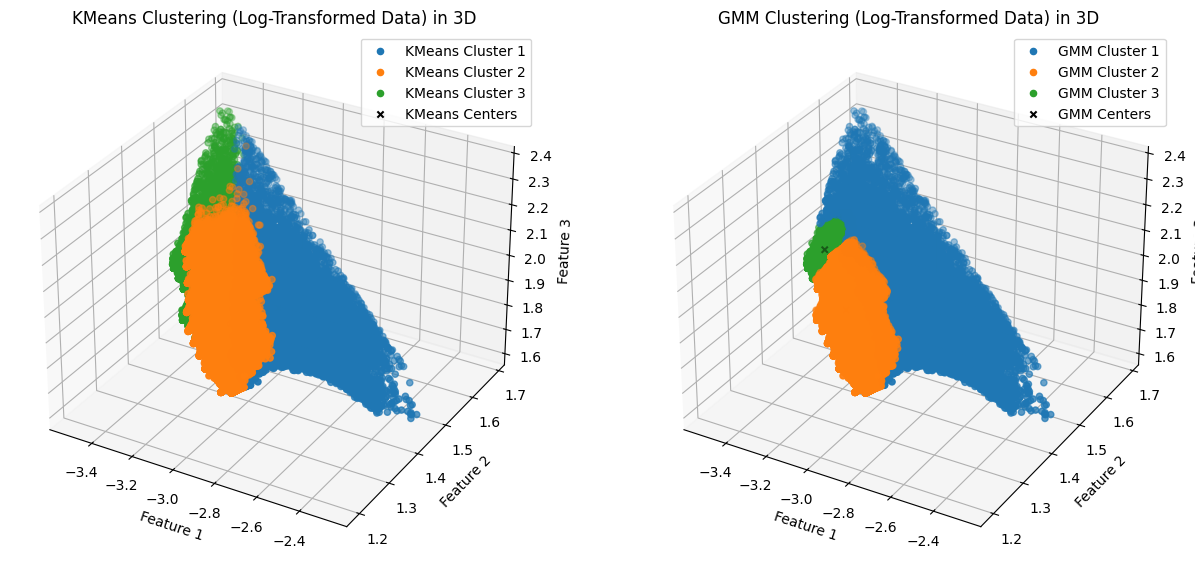

In [ ]:
start_time = time.time()
gmm = GaussianMixture(n_components=k, random_state=42)
gmm.fit(log_transformed_data)
gmm_labels = gmm.predict(log_transformed_data)
gmm_cluster_centers = gmm.means_
gmm_training_time = time.time() - start_time

print(f"GMM Training Time: {gmm_training_time:.4f} seconds")


gmm_cluster_to_label = map_clusters_to_labels(gmm_labels, train_labels)
# gmm_mapped_labels = np.array([gmm_cluster_to_label[cluster] for cluster in gmm_labels])


gmm_wcss = sum(
    np.sum(np.linalg.norm(
        np.dot(log_transformed_data[gmm_labels == i], pseudo_inverse_jl_matrix) -
        np.dot(gmm_cluster_centers[i].reshape(1, -1), pseudo_inverse_jl_matrix),
        axis=1) ** 2)
    for i in range(k)
)

print("GMM WCSS Score:", gmm_wcss)


gmm_transformed_centroids = np.dot(gmm_cluster_centers, pseudo_inverse_jl_matrix)

# print(transformed_centroids.shape)

gmm_predict_clusters = np.argmin(np.linalg.norm(transformed_test_data - gmm_transformed_centroids, axis=2), axis=1)

gmm_mapped_labels = np.array([gmm_cluster_to_label[cluster] for cluster in gmm_predict_clusters])

gmm_accuracy = accuracy_score(test_labels, gmm_mapped_labels)
gmm_rand_index = adjusted_rand_score(test_labels, gmm_mapped_labels)
print(f"GMM Accuracy: {gmm_accuracy * 100:.2f}%")
print(f"GMM RAND Index: {gmm_rand_index:.4f}")


fig = plt.figure(figsize=(15, 8))


ax1 = fig.add_subplot(121, projection='3d')
for i in range(k):
    cluster_points = log_transformed_data[kmeans_labels == i]
    original_cluster_points = np.dot(cluster_points, pseudo_inverse_jl_matrix)
    ax1.scatter(original_cluster_points[:, 0], original_cluster_points[:, 1], original_cluster_points[:, 2], label=f'KMeans Cluster {i+1}')

ax1.scatter(original_dim_kmeans_centers[:, 0], original_dim_kmeans_centers[:, 1], original_dim_kmeans_centers[:, 2],
            marker='x', color='black', label='KMeans Centers')
ax1.set_title('KMeans Clustering (Log-Transformed Data) in 3D')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
ax1.legend()


ax2 = fig.add_subplot(122, projection='3d')
for i in range(k):
    cluster_points = log_transformed_data[gmm_labels == i]
    original_cluster_points = np.dot(cluster_points, pseudo_inverse_jl_matrix)
    ax2.scatter(original_cluster_points[:, 0], original_cluster_points[:, 1], original_cluster_points[:, 2], label=f'GMM Cluster {i+1}')

ax2.scatter(np.dot(gmm_cluster_centers, pseudo_inverse_jl_matrix)[:, 0],
            np.dot(gmm_cluster_centers, pseudo_inverse_jl_matrix)[:, 1],
            np.dot(gmm_cluster_centers, pseudo_inverse_jl_matrix)[:, 2],
            marker='x', color='black', label='GMM Centers')
ax2.set_title('GMM Clustering (Log-Transformed Data) in 3D')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')
ax2.legend()

plt.show()
